# 1. 전처리 및 데이터 준비

In [78]:
import numpy as np
import pandas as pd   
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
# dance_years 매핑
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# 원-핫 인코딩
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=float)

# -------------------------
# 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# 상관계수 높은 변수 사전 삭제 (전처리 단계)
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat','peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')


# -------------------------
# sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 설명용 출력
# -------------------------
print("✅ 최종 데이터셋 컬럼 수:", df.shape[1])
print("sat 중위수:", sat_median)
print(df[['sat', 'sat_group']].head())



✅ 최종 데이터셋 컬럼 수: 178
sat 중위수: 4.0
    sat  sat_group
0  4.00          1
1  4.50          1
2  3.00          0
3  3.00          0
4  4.75          1


In [79]:
import pandas as pd
from scipy.stats import skew, kurtosis, ttest_ind

# 0/1 집단 분리
group1 = df[df['sat_group'] == 1]['sat']
group0 = df[df['sat_group'] == 0]['sat']

# 요약 통계 계산
summary = {
    "group": ["전체", "0집단", "1집단"],
    "n": [df['sat'].count(), group0.count(), group1.count()],
    "mean": [df['sat'].mean(), group0.mean(), group1.mean()],
    "std": [df['sat'].std(), group0.std(), group1.std()],
    "skew": [skew(df['sat']), skew(group0), skew(group1)],
    "kurtosis": [kurtosis(df['sat']), kurtosis(group0), kurtosis(group1)]
}

summary_df = pd.DataFrame(summary).round(3)

# t-test (독립표본)
t_stat, p_val = ttest_ind(group1, group0, equal_var=False)  # Welch’s t-test (이분산 가정)

print("=== sat 요약 통계 ===")
print(summary_df)
print("\n=== 집단 간 T-검정 결과 ===")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


=== sat 요약 통계 ===
  group    n   mean    std   skew  kurtosis
0    전체  355  3.887  0.944 -0.774     0.489
1   0집단  140  2.941  0.680 -1.434     1.807
2   1집단  215  4.502  0.456  0.019    -1.828

=== 집단 간 T-검정 결과 ===
t = 23.903, p = 0.0000


# 2 변수 선택 + RFECV / ElasticNet 파이프라인

In [97]:
# ======================================
# ✅ 최적화 버전: ElasticNet + RFECV(LR/DT/RF/XGB)
# - 변수 선택은 항상 X_train 내부에서 수행
# - 폴드별 선택 변수 → 교집합(안정적 변수) 추출
# - CV(파이프라인 전체) & Hold-out 평가
# - 중복 코드 최소화, 가독성 강화
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

# -------------------------
# 설정
# -------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 존재 확인
# -------------------------
try:
    df
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

# -------------------------
# 타깃/설명변수 설정
# -------------------------
target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

# -------------------------
# 학습/테스트 분할
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# -------------------------
# CV 설정
# -------------------------
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# -------------------------
# RFECV 파이프라인 생성 함수
# -------------------------
def make_rfecv_pipeline(base_estimator, final_estimator=None):
    """RFECV 기반 파이프라인 생성"""
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=inner_cv,
        scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1,
        verbose=0
    )
    return Pipeline([("feature_selection", rfecv), ("clf", final_estimator)])

# -------------------------
# 모델 정의
# -------------------------
models = {
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegressionCV(
            Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
            l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
            max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "RFECV_LR": make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                    LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)),
    "RFECV_DT": make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                    DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RFECV_RF": make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    "RFECV_XGB": make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                     XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
}

# -------------------------
# 폴드별 선택 변수 추출
# -------------------------
def extract_fold_selected(pipe_name, pipe):
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]

        if pipe_name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[enet_fold.coef_.ravel() != 0])
        else:
            # RFECV 모델
            base_map = {
                "RFECV_LR": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                "RFECV_DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
                "RFECV_RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                "RFECV_XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                           eval_metric='logloss', n_jobs=-1)
            }
            rfecv_fold = RFECV(
                estimator=base_map[pipe_name], step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
                n_jobs=1
            )
            rfecv_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    return fold_sets

selected_per_model = {name: extract_fold_selected(name, pipe) for name, pipe in models.items()}

# -------------------------
# Jaccard 안정성 지수
# -------------------------
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2: return np.nan
    scores = []
    from itertools import combinations
    for i,j in combinations(range(len(list_of_sets)),2):
        a, b = list_of_sets[i], list_of_sets[j]
        scores.append(1.0 if len(a|b)==0 else len(a&b)/len(a|b))
    return np.mean(scores)

# -------------------------
# CV & Hold-out 평가
# -------------------------
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring,
                            n_jobs=-1, error_score=np.nan)
    cv_mean = {m: np.nanmean(cv_res[f"test_{m}"]) for m in scoring.keys()}
    cv_std = {m: np.nanstd(cv_res[f"test_{m}"]) for m in scoring.keys()}

    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        try: y_score = fitted_pipe.decision_function(X_test)
        except: y_score = None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()
    jacc = mean_pairwise_jaccard(fold_sets)

    # 최종 선택 변수
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['feature_selection'].support_])
        except: final_selected = []
    elif name == "ElasticNet":
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel()!=0])
        except: final_selected = []

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(list(stable_vars)),
        "final_selected": sorted(final_selected)
    })

# -------------------------
# 결과 정리
# -------------------------
summary_rows = []
for r in results:
    summary_rows.append({
        "model": r["model"],
        "n_stable_vars": len(r["stable_vars"]),
        "stable_vars": ", ".join(r["stable_vars"]),
        "CV_f1_mean": r["cv_mean"]["f1"],
        "CV_acc_mean": r["cv_mean"]["accuracy"],
        "CV_roc_mean": r["cv_mean"]["roc_auc"],
        "Holdout_f1": r["holdout"]["f1"],
        "Holdout_acc": r["holdout"]["accuracy"],
        "Holdout_roc": r["holdout"]["roc_auc"],
        "Jaccard": r["jaccard"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== 요약 표 ===")
display(summary_df)

for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    print("안정적 변수:" + (", ".join(r['stable_vars']) if r['stable_vars'] else " 없음"))
    print(f"최종 선택 변수 수: {len(r['final_selected'])}")
    print("최종 선택 변수:" + (", ".join(r['final_selected']) if r['final_selected'] else " 없음"))



===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 요약 표 ===


,model,n_stable_vars,stable_vars,CV_f1_mean,CV_acc_mean,CV_roc_mean,Holdout_f1,Holdout_acc,Holdout_roc,Jaccard
3,RFECV_RF,81,"admin_serv, ask_q, birth_area_chungcheong, bur...",0.866966,0.830890,0.888623,0.886364,0.859155,0.877907,0.762252
0,ElasticNet,17,"course_variety, know_reason, move_univ, peer_a...",0.856121,0.816917,0.889922,0.873563,0.845070,0.858804,0.471099
4,RFECV_XGB,10,"move_univ, peer_event, prof_access, prof_passi...",0.829109,0.792231,0.873803,0.833333,0.802817,0.867940,0.333155
1,RFECV_LR,8,"abroad_practice, edu_doubt, exp_video, has_inc...",0.788010,0.743045,0.803323,0.790698,0.746479,0.775332,0.295061
2,RFECV_DT,0,,0.730870,0.683020,0.673068,0.746988,0.704225,0.699751,0.184756



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 17
안정적 변수:course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee
최종 선택 변수 수: 91
최종 선택 변수:abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_early, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_abroad, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, major_factor_on_interest, major_factor_total, major_rank, move_univ, peer_advice, peer_career, peer_class, peer_e

In [98]:
# ======================================
# ✅ 전체 통합: RFECV/ElasticNet → stable_vars 추출 → 안정적 변수 기반 모델링
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

# ==========================
# 0️⃣ 설정
# ==========================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# df가 이미 전처리 완료 상태라는 가정
try:
    df
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# ==========================
# 1️⃣ RFECV/ElasticNet 파이프라인 정의
# ==========================
enet_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
        l1_ratios=[.1, .3, .5, .7, .9], scoring="f1",
        max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

def make_rfecv_pipeline(base_estimator, final_estimator=None):
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator, step=1, cv=inner_cv, scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1, verbose=0
    )
    return Pipeline([("feature_selection", rfecv), ("clf", final_estimator)])

models = {
    "ElasticNet": enet_pipeline,
    "RFECV_LR": make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                    LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)),
    "RFECV_DT": make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                    DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RFECV_RF": make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    "RFECV_XGB": make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                     XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
}

# ==========================
# 2️⃣ 폴드별 선택 변수 추출 (stable_vars)
# ==========================
print(">>> 폴드별 선택 변수 계산 중 ...")
selected_per_model = {}

for name, pipe in models.items():
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr_fold = X_train.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]

        if name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1, .3, .5, .7, .9],
                scoring="f1", max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[enet_fold.coef_.ravel() != 0])
        else:
            if name == "RFECV_LR":
                base = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
            elif name == "RFECV_DT":
                base = DecisionTreeClassifier(random_state=RANDOM_STATE)
            elif name == "RFECV_RF":
                base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
            elif name == "RFECV_XGB":
                base = XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                     eval_metric='logloss', n_jobs=-1)
            rfecv_fold = RFECV(
                estimator=base, step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])), n_jobs=1
            )
            rfecv_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    selected_per_model[name] = fold_sets
    intersec = set.intersection(*fold_sets) if fold_sets else set()
    print(f" - {name}: fold별 선택 수 = {[len(s) for s in fold_sets]}, 교집합(안정적) 수 = {len(intersec)}")

# Jaccard 안정성 지수
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2:
        return np.nan
    from itertools import combinations
    scores = [len(list_of_sets[i] & list_of_sets[j]) / len(list_of_sets[i] | list_of_sets[j])
              if len(list_of_sets[i] | list_of_sets[j]) > 0 else 1.0
              for i,j in combinations(range(len(list_of_sets)),2)]
    return np.mean(scores)

# ==========================
# 3️⃣ 파이프라인 전체 CV + Hold-out 평가
# ==========================
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    # CV
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
    cv_mean = {k: np.nanmean(cv_res[f"test_{k}"]) for k in scoring}
    cv_std = {k: np.nanstd(cv_res[f"test_{k}"]) for k in scoring}

    # Hold-out
    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        y_score = fitted_pipe.decision_function(X_test) if hasattr(fitted_pipe, "decision_function") else None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    jacc = mean_pairwise_jaccard(fold_sets)
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()

    # 최종 선택 변수
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try:
            mask = fitted_pipe.named_steps['feature_selection'].support_
            final_selected = list(X_train.columns[mask])
        except: final_selected = []
    elif name == "ElasticNet":
        final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel() != 0])

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(stable_vars),
        "final_selected": sorted(final_selected)
    })

# ==========================
# 4️⃣ 안정적 변수 기반 최종 모델링
# ==========================
final_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                         use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

stable_vars_dict = {r["model"]: r["stable_vars"] for r in results}
results_final = []

for source, stable_vars in stable_vars_dict.items():
    if not stable_vars:
        results_final.append({"source": source, "model": None, "n_features":0})
        continue
    for m_name, clf in final_models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)]) if m_name=="LogReg" else Pipeline([("clf", clf)])
        # CV
        cv_res = cross_validate(pipe, X_train[stable_vars], y_train, cv=outer_cv, scoring=scoring, n_jobs=-1)
        cv_mean = {k: np.mean(cv_res[f"test_{k}"]) for k in scoring}
        cv_std = {k: np.std(cv_res[f"test_{k}"]) for k in scoring}
        # Hold-out
        pipe.fit(X_train[stable_vars], y_train)
        y_pred = pipe.predict(X_test[stable_vars])
        try: y_score = pipe.predict_proba(X_test[stable_vars])[:,1]
        except: y_score = pipe.decision_function(X_test[stable_vars])
        holdout = {
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_acc": balanced_accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score),
            "mcc": matthews_corrcoef(y_test, y_pred)
        }
        results_final.append({
            "source": source,
            "model": m_name,
            "n_features": len(stable_vars),
            **{f"CV_{k}_mean": v for k,v in cv_mean.items()},
            **{f"CV_{k}_std": cv_std[k] for k in scoring},
            **{f"Test_{k}": v for k,v in holdout.items()}
        })

results_final_df = pd.DataFrame(results_final)
print("\n\n=== 안정적 변수 기반 최종 성능표 ===")
display(results_final_df.sort_values(by="CV_f1_mean", ascending=False))

# ==========================
# 5️⃣ 상세 안정적 변수 / 최종 선택 변수 출력
# ==========================
for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    if r['stable_vars']: print("안정적 변수 (알파벳순):", ", ".join(r['stable_vars']))
    else: print("안정적 변수: 없음")
    print(f"파이프라인 기반 최종 선택 변수 수: {len(r['final_selected'])}")
    if r['final_selected']: print("최종 선택 변수 (알파벳순):", ", ".join(r['final_selected']))


>>> 폴드별 선택 변수 계산 중 ...
 - ElasticNet: fold별 선택 수 = [30, 30, 62, 63, 24], 교집합(안정적) 수 = 17
 - RFECV_LR: fold별 선택 수 = [16, 58, 55, 53, 59], 교집합(안정적) 수 = 8
 - RFECV_DT: fold별 선택 수 = [131, 8, 10, 157, 46], 교집합(안정적) 수 = 0
 - RFECV_RF: fold별 선택 수 = [144, 156, 128, 82, 149], 교집합(안정적) 수 = 81
 - RFECV_XGB: fold별 선택 수 = [73, 16, 75, 64, 32], 교집합(안정적) 수 = 10

===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 안정적 변수 기반 최종 성능표 ===


,source,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,Test_mcc
11,RFECV_RF,RF,81,0.827444,0.861837,0.896256,0.045001,0.036965,0.033380,0.830986,0.810631,0.866667,0.829787,0.906977,0.877907,0.641850
13,RFECV_XGB,LogReg,10,0.823997,0.859121,0.905440,0.051865,0.039870,0.046934,0.774648,0.770349,0.809524,0.829268,0.790698,0.860050,0.534952
2,ElasticNet,RF,17,0.816855,0.851804,0.901064,0.049290,0.041428,0.043440,0.788732,0.781977,0.823529,0.833333,0.813953,0.893688,0.560703
15,RFECV_XGB,RF,10,0.820301,0.851421,0.882684,0.065459,0.055146,0.056916,0.830986,0.823090,0.860465,0.860465,0.860465,0.897425,0.646179
3,ElasticNet,XGB,17,0.820489,0.850968,0.889023,0.041838,0.038636,0.028696,0.746479,0.747093,0.780488,0.820513,0.744186,0.877907,0.485396
0,ElasticNet,LogReg,17,0.820551,0.850605,0.902116,0.049738,0.047106,0.042281,0.774648,0.776578,0.804878,0.846154,0.767442,0.874585,0.543317
12,RFECV_RF,XGB,81,0.813283,0.848816,0.869650,0.029185,0.024387,0.040721,0.845070,0.840947,0.870588,0.880952,0.860465,0.877907,0.677963
16,RFECV_XGB,XGB,10,0.802757,0.836898,0.874127,0.057215,0.051440,0.038137,0.802817,0.799834,0.833333,0.853659,0.813953,0.898256,0.593296
4,RFECV_LR,LogReg,8,0.792293,0.831643,0.880595,0.038848,0.031964,0.020964,0.704225,0.705980,0.740741,0.789474,0.697674,0.796927,0.403664
9,RFECV_RF,LogReg,81,0.792544,0.828418,0.860255,0.042695,0.037322,0.038844,0.760563,0.771179,0.784810,0.861111,0.720930,0.837209,0.530169



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 17
안정적 변수 (알파벳순): course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee
파이프라인 기반 최종 선택 변수 수: 91
최종 선택 변수 (알파벳순): abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_early, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_abroad, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, major_factor_on_interest, major_factor_total, major_rank, move_univ, peer_advice, peer_c


=== Top3 후보 모델 (복합 지표 기준) ===


,source,model,n_features,Test_f1,Test_roc_auc,Test_balanced_acc,composite_score
0,RFECV_RF,XGB,81,0.870588,0.877907,0.840947,2.589442
1,RFECV_XGB,RF,10,0.860465,0.897425,0.823090,2.580980
2,RFECV_RF,RF,81,0.866667,0.877907,0.810631,2.555205



>>> 분석 중: RFECV_RF - XGB (n_features=81)


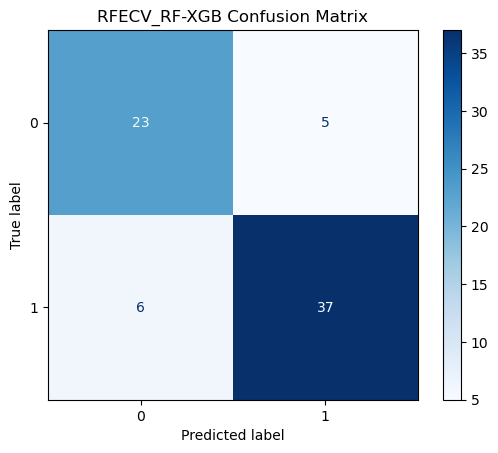

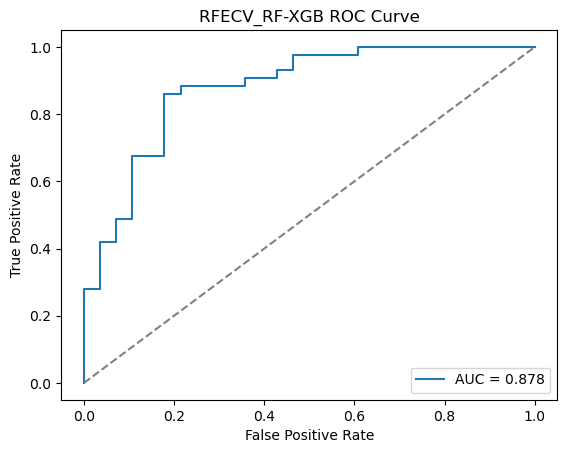

RFECV_RF-XGB SHAP summary plot (Class 1: 고만족)


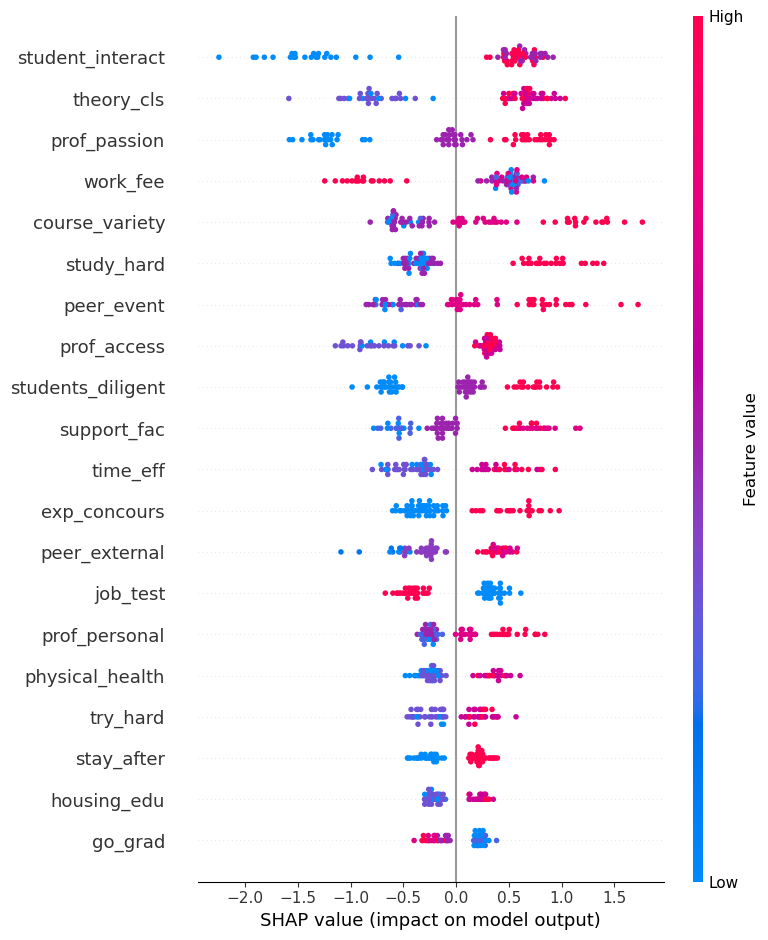

RFECV_RF-XGB 변수별 SHAP 값 (저만족 vs 고만족 비교)


,feature,mean_shap_class0,mean_abs_shap_class0,mean_shap_class1,mean_abs_shap_class1
61,student_interact,0.042973,0.873929,-0.042973,0.873929
67,theory_cls,-0.082640,0.730696,0.082640,0.730696
54,prof_passion,0.143576,0.654827,-0.143576,0.654827
79,work_fee,-0.159270,0.609322,0.159270,0.609322
8,course_variety,-0.125195,0.594917,0.125195,0.594917
63,study_hard,-0.046183,0.543707,0.046183,0.543707
42,peer_event,-0.047998,0.530738,0.047998,0.530738
46,prof_access,0.113024,0.492392,-0.113024,0.492392
62,students_diligent,0.007687,0.469491,-0.007687,0.469491
65,support_fac,-0.054604,0.448438,0.054604,0.448438



>>> 분석 중: RFECV_XGB - RF (n_features=10)


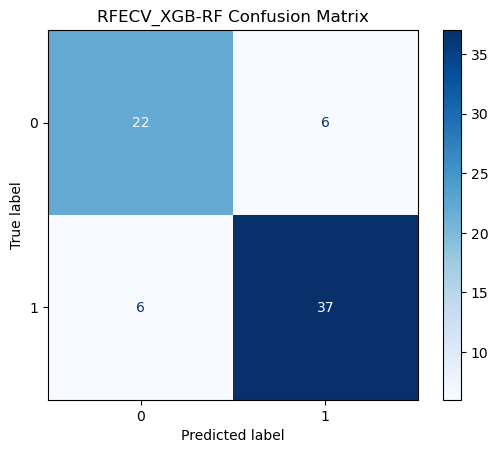

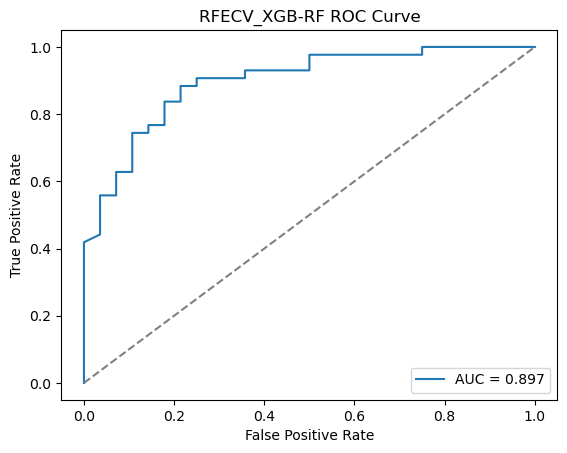

RFECV_XGB-RF SHAP summary plot (Class 1: 고만족)


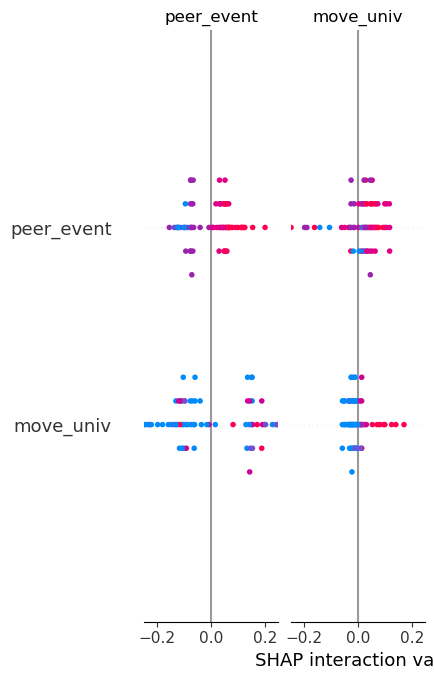

ValueError: Per-column arrays must each be 1-dimensional

In [108]:
# ======================================
# ✅ Top3 안정적 변수 기반 모델 분석 및 Top1 선정 (복합 지표)
# ======================================

import matplotlib.pyplot as plt
import shap
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# ------------------------------
# 1️⃣ 복합 지표 계산
# ------------------------------
results_final_df["composite_score"] = (
    results_final_df["Test_f1"] +
    results_final_df["Test_roc_auc"] +
    results_final_df["Test_balanced_acc"]
)

# ------------------------------
# 2️⃣ Top3 모델 선택 (복합 지표 기준)
# ------------------------------
top3_df = results_final_df.sort_values(by="composite_score", ascending=False).head(3)
top3_df.reset_index(drop=True, inplace=True)
print("\n=== Top3 후보 모델 (복합 지표 기준) ===")
display(top3_df[["source", "model", "n_features", 
                 "Test_f1", "Test_roc_auc", "Test_balanced_acc", "composite_score"]])

# ------------------------------
# 3️⃣ Top3 모델 학습 + SHAP/Confusion/ROC 시각화 + SHAP 수치
# ------------------------------
top1_info = None  # 최종 Top1 모델 저장
for idx, row in top3_df.iterrows():
    source = row["source"]
    model_name = row["model"]
    stable_vars = stable_vars_dict[source]
    clf = final_models[model_name]

    print(f"\n>>> 분석 중: {source} - {model_name} (n_features={len(stable_vars)})")

    # 조건부 스케일링
    if model_name == "LogReg":
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    else:
        pipe = Pipeline([("clf", clf)])

    # 학습
    pipe.fit(X_train[stable_vars], y_train)
    y_pred = pipe.predict(X_test[stable_vars])
    try:
        y_score = pipe.predict_proba(X_test[stable_vars])[:, 1]
    except:
        y_score = pipe.decision_function(X_test[stable_vars])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{source}-{model_name} Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title(f"{source}-{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # SHAP 값 계산
    if model_name in ["RF", "XGB"]:
        explainer = shap.TreeExplainer(pipe.named_steps['clf'])
        shap_values = explainer.shap_values(X_test[stable_vars])
    else:
        explainer = shap.LinearExplainer(
            pipe.named_steps['clf'], 
            X_train[stable_vars], 
            feature_perturbation="interventional"
        )
        shap_values = explainer.shap_values(X_test[stable_vars])

    # Tree 모델은 list 반환 → (class0, class1)
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_class0 = shap_values[0]
        shap_values_class1 = shap_values[1]
    else:
        # LinearExplainer는 (n_samples, n_features)
        # shap_values는 "log-odds 기준 → class1" 기여도
        shap_values_class1 = shap_values
        shap_values_class0 = -shap_values_class1

    # SHAP summary plot (양성 클래스)
    print(f"{source}-{model_name} SHAP summary plot (Class 1: 고만족)")
    shap.summary_plot(shap_values_class1, X_test[stable_vars], show=True)

    # ✅ SHAP 수치 비교 (저만족 vs 고만족)
    mean_shap_0 = shap_values_class0.mean(axis=0)
    mean_abs_shap_0 = np.abs(shap_values_class0).mean(axis=0)

    mean_shap_1 = shap_values_class1.mean(axis=0)
    mean_abs_shap_1 = np.abs(shap_values_class1).mean(axis=0)

    shap_df = pd.DataFrame({
        "feature": stable_vars,
        "mean_shap_class0": mean_shap_0,
        "mean_abs_shap_class0": mean_abs_shap_0,
        "mean_shap_class1": mean_shap_1,
        "mean_abs_shap_class1": mean_abs_shap_1
    }).sort_values(by="mean_abs_shap_class1", ascending=False)

    print(f"{source}-{model_name} 변수별 SHAP 값 (저만족 vs 고만족 비교)")
    display(shap_df)

    # Top1 후보 선정 (복합 지표 기준 → 첫 번째가 Top1)
    if idx == 0:
        top1_info = {
            "source": source,
            "model_name": model_name,
            "stable_vars": stable_vars,
            "pipeline": pipe,
            "y_pred": y_pred,
            "y_score": y_score,
            "shap_df": shap_df
        }

# ------------------------------
# 4️⃣ 최종 Top1 모델 정보
# ------------------------------
print("\n=== 최종 Top1 모델 ===")
print(f"Source: {top1_info['source']}")
print(f"Model: {top1_info['model_name']}")
print(f"n_features: {len(top1_info['stable_vars'])}")
print(f"Stable variables: {', '.join(top1_info['stable_vars'])}")


In [107]:
print("shap_values shape:", np.array(shap_values).shape)
print("mean_shap shape:", mean_shap.shape)
print("mean_abs_shap shape:", mean_abs_shap.shape)


shap_values shape: (71, 10, 2)
mean_shap shape: (10, 2)
mean_abs_shap shape: (10, 2)


______________________________________#################

In [110]:
# ======================================
# ElasticNet(LogisticRegressionCV) 최적 하이퍼파라미터 확인
# ======================================

# 1) 파이프라인 학습
enet_pipeline.fit(X_train, y_train)

# 2) 최적 하이퍼파라미터 확인
best_Cs = enet_pipeline.named_steps['clf'].C_       # fold별 최적 C 값 (배열)
best_l1  = enet_pipeline.named_steps['clf'].l1_ratio_  # 최적 l1_ratio (배열)

print("ElasticNet 최적 C 값 (fold별):", best_Cs)
print("ElasticNet 최적 l1_ratio (fold별):", best_l1)


ElasticNet 최적 C 값 (fold별): [0.04641589]
ElasticNet 최적 l1_ratio (fold별): [0.1]


# 여기부터 다시 

In [111]:
import pandas as pd
import numpy as np

# ---------------------------------
# 1️⃣ Hold-out + CV 평균 + 안정적 변수 수 등 고려해서 Top5 선정
# ---------------------------------
df_res = results_final_df.copy()

# CV-Test F1 gap 계산
df_res['CV-Test_F1_gap'] = df_res['CV_f1_mean'] - df_res['Test_f1']

# 종합 점수: Hold-out F1, Balanced Accuracy, MCC, ROC-AUC 평균에서 CV-Test gap 패널티
df_res['score_combined'] = df_res[['Test_f1', 'Test_balanced_acc', 'Test_mcc', 'Test_roc_auc']].mean(axis=1) - df_res['CV-Test_F1_gap'].abs()

# Top5 선정
top5_df = df_res.sort_values(by='score_combined', ascending=False).head(5).reset_index(drop=True)

# 소수점 3자리 반올림 (존재하는 컬럼만)
num_cols = ['CV_f1_mean', 'CV_roc_auc_mean', 'Test_f1', 'Test_balanced_acc', 'Test_mcc', 'Test_roc_auc', 'score_combined', 'CV-Test_F1_gap']
num_cols = [c for c in num_cols if c in top5_df.columns]
top5_df[num_cols] = top5_df[num_cols].round(3)

# 결과 출력
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print("=== 안정적 변수 기반 모델 Top5 (Hold-out 중심, CV/안정성 고려) ===")
display(top5_df[['source', 'model', 'n_features'] + num_cols])


=== 안정적 변수 기반 모델 Top5 (Hold-out 중심, CV/안정성 고려) ===


,source,model,n_features,CV_f1_mean,CV_roc_auc_mean,Test_f1,Test_balanced_acc,Test_mcc,Test_roc_auc,score_combined,CV-Test_F1_gap
0,RFECV_XGB,RF,10,0.851,0.883,0.860,0.823,0.646,0.897,0.798,-0.009
1,RFECV_RF,XGB,81,0.849,0.870,0.871,0.841,0.678,0.878,0.795,-0.022
2,RFECV_RF,RF,81,0.862,0.896,0.867,0.811,0.642,0.878,0.794,-0.005
3,RFECV_XGB,XGB,10,0.837,0.874,0.833,0.800,0.593,0.898,0.778,0.004
4,ElasticNet,RF,17,0.852,0.901,0.824,0.782,0.561,0.894,0.737,0.028


=== Confusion Matrix (RFECV_XGB + RF) ===
[[22  6]
 [ 6 37]]


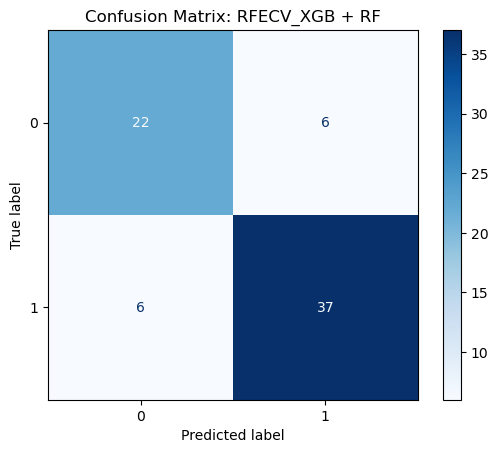

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1️⃣ RFECV_XGB의 안정적 변수 불러오기
stable_vars_xgb = stable_vars_dict["RFECV_XGB"]

# 2️⃣ RandomForest 학습 (source=RFECV_XGB, model=RF)
rf_clf = RandomForestClassifier(
    n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1
)

rf_clf.fit(X_train[stable_vars_xgb], y_train)

# 3️⃣ 예측
y_pred_rf = rf_clf.predict(X_test[stable_vars_xgb])

# 4️⃣ Confusion Matrix 계산 및 시각화
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

print("=== Confusion Matrix (RFECV_XGB + RF) ===")
print(cm)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: RFECV_XGB + RF")
plt.show()


In [113]:
# enet, rfecv(rf) 안정적 변수 다중공선성 확인

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 안정적 변수 리스트
# -------------------------------
enet_vars = [
    "course_variety", "know_reason", "move_univ", "peer_advice", "peer_event",
    "peer_external", "prof_access", "prof_event", "prof_passion", "student_interact",
    "students_diligent", "study_hard", "support_fac", "theory_cls", "time_eff",
    "try_hard", "work_fee"
]

rf_vars = [
    "admin_serv", "ask_q", "birth_area_chungcheong", "burnout", "car_spt", "change_career", "change_major",
    "cont_major", "course_variety", "dance_years", "drink_freq", "drop_out", "edu_doubt", "exercise_reg", 
    "exp_concours", "exp_group_comp", "exp_solo_comp", "find_data", "fit_major", "get_fdbk", "go_abroad", "go_grad", "grade",
    "housing_culture", "housing_edu", "housing_green", "housing_hygiene", "housing_infra", "housing_neighbor", "housing_safety",
    "housing_transit", "housing_type_parents", "intern_abroad", "job_test", "know_reason", "learn_fun", "lecture_fac", "mental_health",
    "move_univ", "peer_advice", "peer_career", "peer_class", "peer_event", "peer_external", "physical_health", "prac_cls",
    "prof_access", "prof_career", "prof_class_talk", "prof_effort", "prof_event", "prof_exp", "prof_grade", "prof_other_talk",
    "prof_passion", "prof_personal", "real_appl", "scholarship", "self_study", "smoke_exp", "stay_after", "student_interact", 
    "students_diligent", "study_hard", "study_mate", "support_fac", "take_leave", "theory_cls", "time_eff", "transport", "try_fail",
    "try_hard", "tuition", "univ_course_year", "univ_factor_prefer_prof", "univ_factor_social_reputation", "univ_name_bau",
    "univ_name_swu", "univ_rank", "work_fee", "write_vol"

]

xgb_vars = ["move_univ", "peer_event", "prof_access", "prof_passion", "student_interact", "students_diligent",
    "study_hard", "theory_cls", "time_eff", "univ_factor_prefer_prof"]

# -------------------------------
# 상관계수 계산
# -------------------------------
enet_corr = X_train[enet_vars].corr()
rf_corr = X_train[rf_vars].corr()
xgb_corr = X_train[xgb_vars].corr()

print("=== ElasticNet 안정적 변수 상관계수 ===")
display(enet_corr)

print("=== RFECV(Random Forest) 안정적 변수 상관계수 ===")
display(rf_corr)

print("=== RFECV(XGBoost) 안정적 변수 상관계수 ===")
display(xgb_corr)
# -------------------------------
# VIF 계산 함수
# -------------------------------
def compute_vif(df):
    # 표준화
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
    vif_data = pd.DataFrame()
    vif_data["variable"] = X_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
    return vif_data

enet_vif = compute_vif(X_train[enet_vars])
rf_vif = compute_vif(X_train[rf_vars])
xgb_vif = compute_vif(X_train[xgb_vars])
print("=== ElasticNet 안정적 변수 VIF ===")
display(enet_vif.sort_values("VIF", ascending=False))

print("=== RFECV(Random Forest) 안정적 변수 VIF ===")
display(rf_vif.sort_values("VIF", ascending=False))

print("=== RFECV(XGBoost) 안정적 변수 VIF ===")
display(xgb_vif.sort_values("VIF", ascending=False))


=== ElasticNet 안정적 변수 상관계수 ===


,course_variety,know_reason,move_univ,peer_advice,peer_event,peer_external,prof_access,prof_event,prof_passion,student_interact,students_diligent,study_hard,support_fac,theory_cls,time_eff,try_hard,work_fee
course_variety,1.000000,0.423892,-0.246423,0.372073,0.396986,0.326622,0.454912,0.511667,0.570648,0.373421,0.504104,0.258295,0.274178,0.516288,0.313049,0.279932,-0.106829
know_reason,0.423892,1.000000,-0.224455,0.296050,0.321451,0.243037,0.417611,0.356360,0.438484,0.333923,0.354356,0.523859,0.179067,0.384324,0.435006,0.460663,-0.063508
move_univ,-0.246423,-0.224455,1.000000,-0.209670,-0.227099,-0.231037,-0.191757,-0.274747,-0.217283,-0.206513,-0.233540,-0.117032,-0.135972,-0.214862,-0.227097,-0.141370,0.145344
peer_advice,0.372073,0.296050,-0.209670,1.000000,0.743578,0.729816,0.465187,0.470878,0.454889,0.404733,0.376110,0.274403,0.188882,0.385195,0.213721,0.316472,-0.005878
peer_event,0.396986,0.321451,-0.227099,0.743578,1.000000,0.759627,0.445654,0.526881,0.472275,0.434386,0.403225,0.235298,0.208726,0.377330,0.217708,0.230805,-0.032852
peer_external,0.326622,0.243037,-0.231037,0.729816,0.759627,1.000000,0.428794,0.443666,0.370852,0.401288,0.368850,0.148419,0.178963,0.318088,0.151234,0.220020,-0.032687
prof_access,0.454912,0.417611,-0.191757,0.465187,0.445654,0.428794,1.000000,0.551164,0.699161,0.464247,0.505152,0.329223,0.206037,0.483914,0.348531,0.343895,-0.132410
prof_event,0.511667,0.356360,-0.274747,0.470878,0.526881,0.443666,0.551164,1.000000,0.545631,0.316486,0.344032,0.314953,0.282078,0.411634,0.307652,0.274172,-0.118328
prof_passion,0.570648,0.438484,-0.217283,0.454889,0.472275,0.370852,0.699161,0.545631,1.000000,0.546087,0.566455,0.342254,0.230391,0.516605,0.369803,0.316799,-0.118191
student_interact,0.373421,0.333923,-0.206513,0.404733,0.434386,0.401288,0.464247,0.316486,0.546087,1.000000,0.452273,0.227978,0.091531,0.370080,0.287820,0.323114,-0.132217


=== RFECV(Random Forest) 안정적 변수 상관계수 ===


,admin_serv,ask_q,birth_area_chungcheong,burnout,car_spt,change_career,change_major,cont_major,course_variety,dance_years,drink_freq,drop_out,edu_doubt,exercise_reg,exp_concours,exp_group_comp,exp_solo_comp,find_data,fit_major,get_fdbk,go_abroad,go_grad,grade,housing_culture,housing_edu,housing_green,housing_hygiene,housing_infra,housing_neighbor,housing_safety,housing_transit,housing_type_parents,intern_abroad,job_test,know_reason,learn_fun,lecture_fac,mental_health,move_univ,peer_advice,peer_career,peer_class,peer_event,peer_external,physical_health,prac_cls,prof_access,prof_career,prof_class_talk,prof_effort,prof_event,prof_exp,prof_grade,prof_other_talk,prof_passion,prof_personal,real_appl,scholarship,self_study,smoke_exp,stay_after,student_interact,students_diligent,study_hard,study_mate,support_fac,take_leave,theory_cls,time_eff,transport,try_fail,try_hard,tuition,univ_course_year,univ_factor_prefer_prof,univ_factor_social_reputation,univ_name_bau,univ_name_swu,univ_rank,work_fee,write_vol
admin_serv,1.000000,0.105885,-0.050563,-0.067942,0.788702,-0.293744,-0.250190,0.320421,0.460273,0.064907,0.053392,-0.215611,0.100272,0.085614,0.032956,0.079293,0.072705,0.175302,0.359899,0.275125,-0.134162,0.078357,-0.116010,0.150592,0.020618,0.157421,0.038829,0.106175,0.023050,0.059168,0.024739,-0.033197,0.645618,0.048245,0.392642,0.385522,0.609058,0.250353,-0.246768,0.316493,0.304224,0.326736,0.349845,0.273000,0.211913,0.559162,0.482974,0.385085,0.212933,0.605664,0.397101,0.419853,0.328472,0.204554,0.520144,0.323882,0.210527,0.512923,0.177851,-0.072903,-0.055249,0.320377,0.355382,0.240809,0.221491,0.435866,-0.200926,0.611560,0.323999,0.204297,0.189891,0.271698,0.442340,0.030326,-0.050563,0.057560,-0.096492,0.039725,-0.209483,-0.130333,0.149259
ask_q,0.105885,1.000000,-0.031170,0.063885,0.163405,-0.203621,-0.143447,0.372230,0.176501,0.033988,0.028181,-0.159814,0.010515,0.199275,-0.043865,-0.090308,0.021141,0.438939,0.279487,0.489598,0.097390,0.149111,0.060057,0.109882,0.068041,0.134228,0.057467,0.070331,0.144602,0.046493,0.019830,-0.057604,0.079746,-0.021402,0.350269,0.354277,0.136046,0.098668,-0.005898,0.219878,0.183314,0.219733,0.138213,0.117198,0.146792,0.152021,0.185500,0.207491,0.231977,0.189394,0.268875,0.301732,0.288363,0.254562,0.178978,0.223140,0.440006,0.121303,0.384618,0.052599,-0.066505,0.123666,0.109549,0.400004,0.283429,0.114451,-0.137466,0.190785,0.235671,-0.066686,0.351651,0.447680,0.163315,-0.052496,0.014637,-0.105522,-0.205179,0.022575,-0.024663,-0.034232,0.348706
birth_area_chungcheong,-0.050563,-0.031170,1.000000,0.029281,-0.045231,0.000327,0.082528,-0.059429,0.019519,-0.026215,-0.015447,0.099747,-0.083048,-0.035778,-0.010355,0.038006,-0.020211,0.071500,-0.075482,-0.104136,-0.046567,-0.071113,-0.069542,0.017576,0.032340,0.007458,0.012328,-0.016348,0.047046,0.013724,-0.014975,-0.135839,-0.003764,-0.061379,-0.069229,0.015287,0.021543,-0.102615,0.035675,-0.107251,-0.144595,-0.077631,-0.062170,-0.119992,-0.032960,0.015987,-0.056017,-0.065828,-0.053695,0.014213,0.013165,0.001983,0.018447,-0.020133,-0.028869,-0.047700,-0.091615,-0.103559,-0.127312,-0.022575,-0.016441,-0.068506,-0.107432,-0.079360,-0.185359,-0.070885,0.085906,0.008994,-0.000912,-0.097474,-0.080503,-0.031893,0.000550,-0.014389,0.053806,-0.025411,-0.047791,-0.012394,0.142043,-0.076199,0.054102
burnout,-0.067942,0.063885,0.029281,1.000000,-0.030398,0.210624,0.142016,-0.017362,-0.049438,0.175900,-0.007602,0.118503,-0.058885,0.000258,0.039396,0.047299,0.001207,-0.013908,-0.048790,0.020379,0.150204,0.083146,0.213859,-0.051239,0.009786,0.004613,0.005851,-0.050044,-0.018685,0.108303,-0.011180,-0.005990,-0.035523,0.018595,0.007480,0.025931,-0.051718,-0.351538,0.133787,0.126796,0.081377,0.072383,0.103994,0.070471,-0.273637,-0.047737,-0.043322,-0.038614,0.034499,-0.020194,0.006885,0.050103,-0.040717,0.049613,0.003763,-0.011406,0.109235,-0.027505,0.034744,0.079864,-0.080002,0.030100,0.037101,-0.007498,0.041475,-0.119606,0.119017,-0.062133,-0.067379,-0.094540,0.071357

=== RFECV(XGBoost) 안정적 변수 상관계수 ===


,move_univ,peer_event,prof_access,prof_passion,student_interact,students_diligent,study_hard,theory_cls,time_eff,univ_factor_prefer_prof
move_univ,1.000000,-0.227099,-0.191757,-0.217283,-0.206513,-0.233540,-0.117032,-0.214862,-0.227097,0.023320
peer_event,-0.227099,1.000000,0.445654,0.472275,0.434386,0.403225,0.235298,0.377330,0.217708,0.008549
prof_access,-0.191757,0.445654,1.000000,0.699161,0.464247,0.505152,0.329223,0.483914,0.348531,0.012144
prof_passion,-0.217283,0.472275,0.699161,1.000000,0.546087,0.566455,0.342254,0.516605,0.369803,0.003095
student_interact,-0.206513,0.434386,0.464247,0.546087,1.000000,0.452273,0.227978,0.370080,0.287820,0.005190
students_diligent,-0.233540,0.403225,0.505152,0.566455,0.452273,1.000000,0.201931,0.386672,0.228604,-0.092657
study_hard,-0.117032,0.235298,0.329223,0.342254,0.227978,0.201931,1.000000,0.225536,0.530306,0.044704
theory_cls,-0.214862,0.377330,0.483914,0.516605,0.370080,0.386672,0.225536,1.000000,0.220856,-0.003466
time_eff,-0.227097,0.217708,0.348531,0.369803,0.287820,0.228604,0.530306,0.220856,1.000000,0.053590
univ_factor_prefer_prof,0.023320,0.008549,0.012144,0.003095,0.005190,-0.092657,0.044704,-0.003466,0.053590,1.000000


=== ElasticNet 안정적 변수 VIF ===


,variable,VIF
4,peer_event,3.238610
5,peer_external,2.931787
3,peer_advice,2.861085
8,prof_passion,2.841874
6,prof_access,2.410266
7,prof_event,1.974237
0,course_variety,1.943875
11,study_hard,1.844593
1,know_reason,1.802370
10,students_diligent,1.765631


=== RFECV(Random Forest) 안정적 변수 VIF ===


,variable,VIF
45,prac_cls,6.055062
49,prof_effort,5.871510
55,prof_personal,5.777849
0,admin_serv,5.675973
4,car_spt,5.628758
40,peer_career,5.511040
42,peer_event,5.162727
47,prof_career,5.161096
41,peer_class,4.924374
54,prof_passion,4.848876


=== RFECV(XGBoost) 안정적 변수 VIF ===


,variable,VIF
3,prof_passion,2.612543
2,prof_access,2.181192
5,students_diligent,1.651781
4,student_interact,1.586430
8,time_eff,1.535291
7,theory_cls,1.477988
6,study_hard,1.461490
1,peer_event,1.460941
0,move_univ,1.125847
9,univ_factor_prefer_prof,1.019447


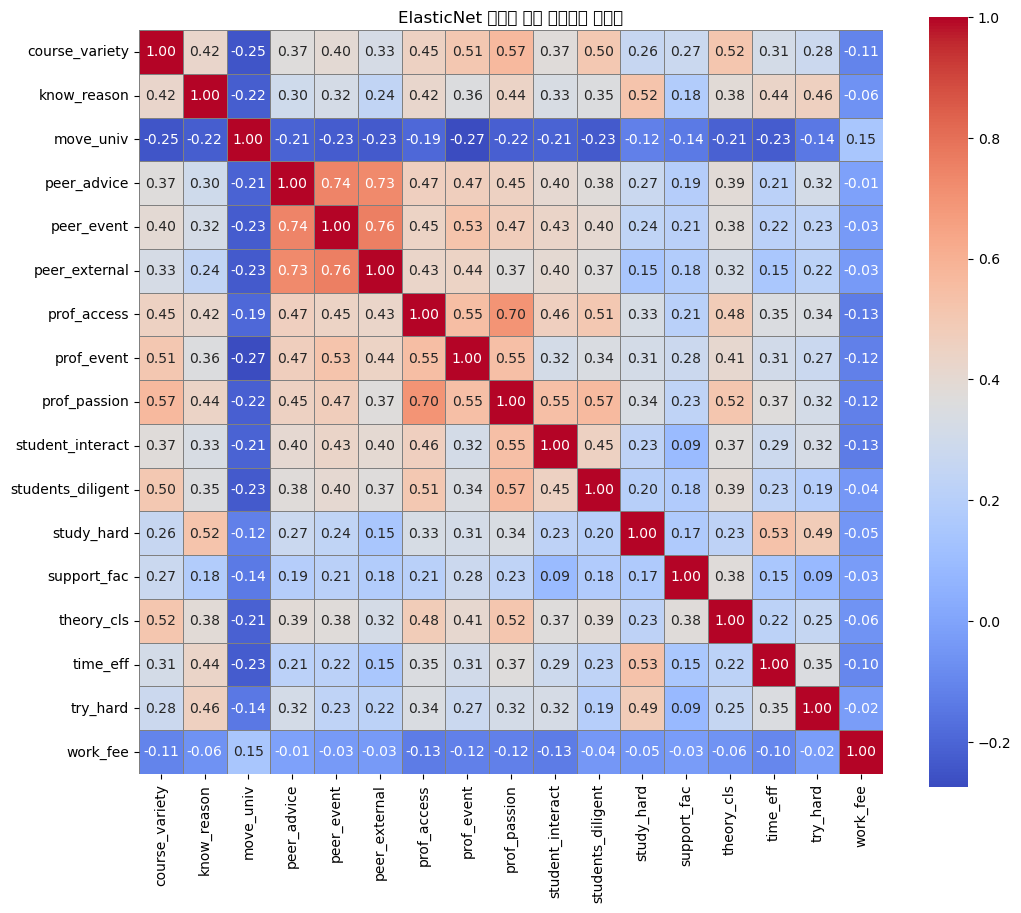

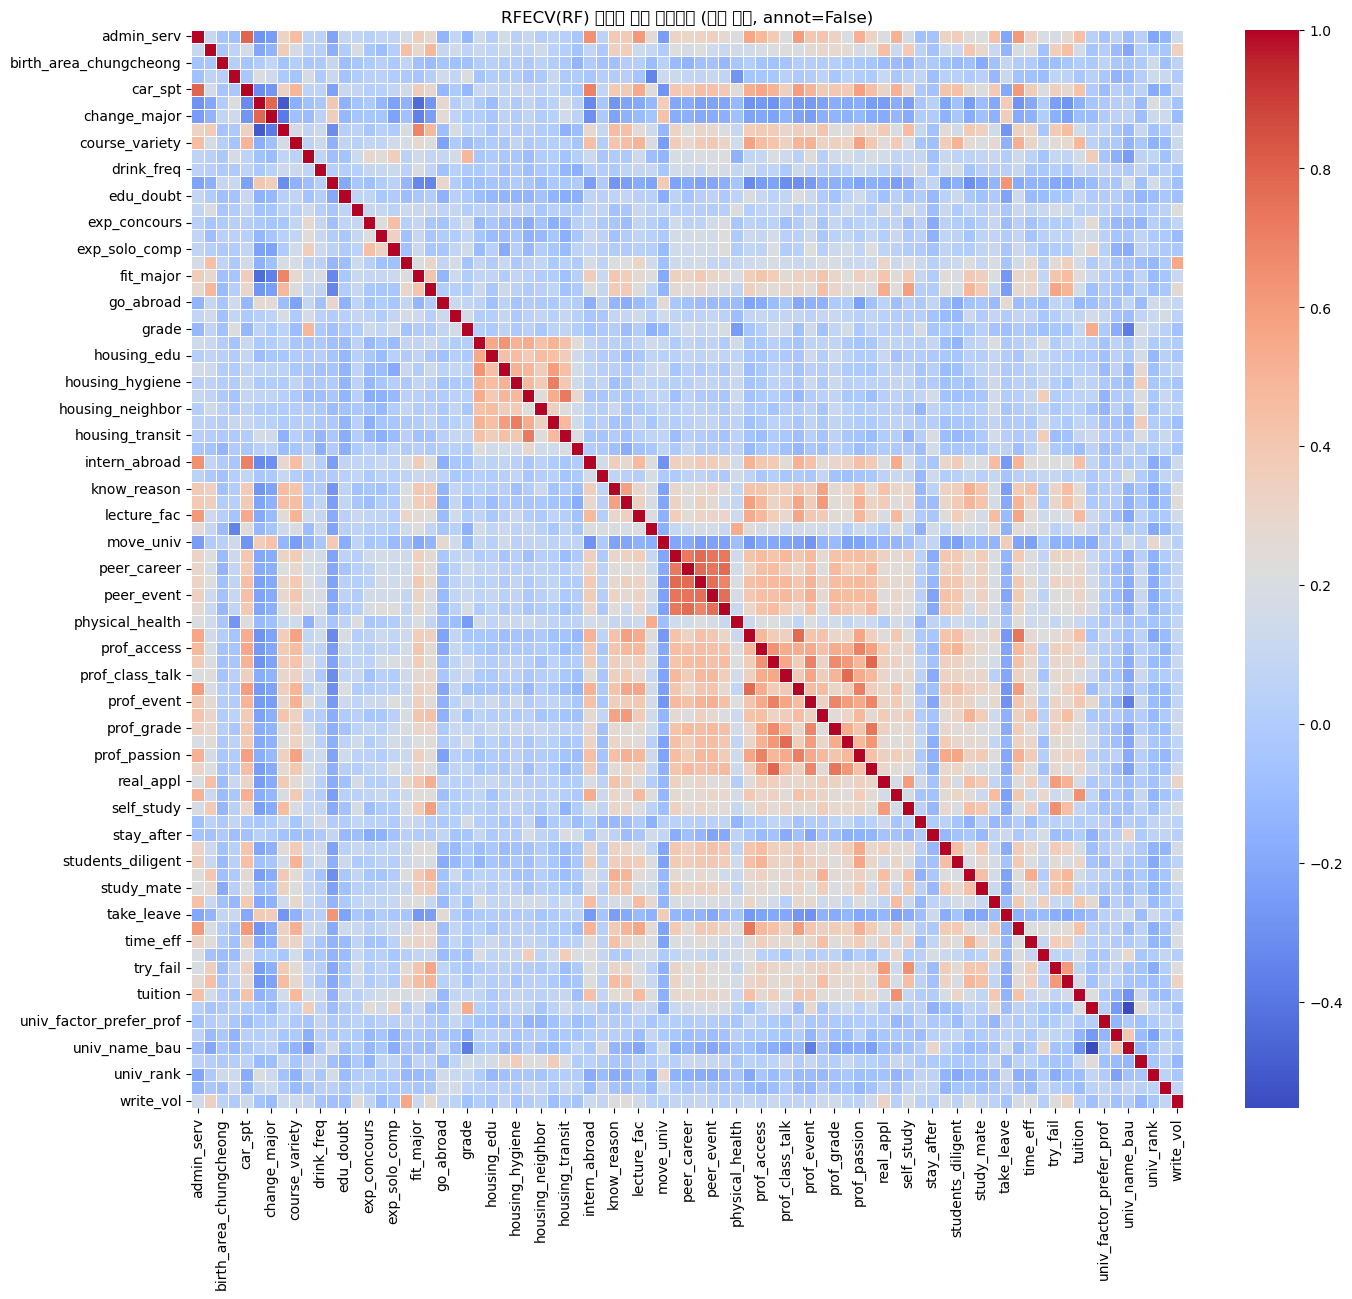

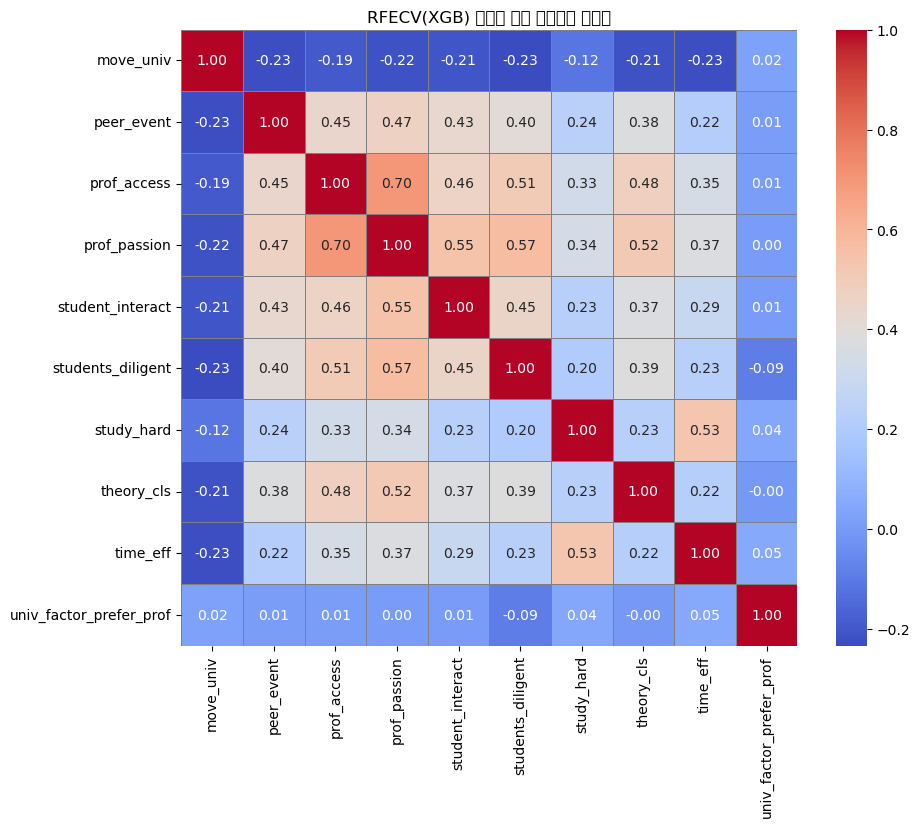

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# ElasticNet 안정적 변수 상관계수 히트맵
# -------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(enet_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            square=True, linewidths=0.5, linecolor='gray')
plt.title("ElasticNet 안정적 변수 상관계수 히트맵")
plt.show()

# -------------------------------
# RFECV(Random Forest) 안정적 변수 상관계수 히트맵
# -------------------------------
plt.figure(figsize=(16,14))
sns.heatmap(rf_corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("RFECV(RF) 안정적 변수 상관계수 (글자 회전, annot=False)")
plt.show()

# -------------------------------
# RFECV(XGBOOST) 안정적 변수 상관계수 히트맵 
# -------------------------------
plt.figure(figsize=(10,8))
sns.heatmap(xgb_corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor='gray', square=True)
plt.title("RFECV(XGB) 안정적 변수 상관계수 히트맵")
plt.show()



# 4. 상위 5개 모델 상세 성능

In [75]:
# Top 5 모델 선정
df_res["score_combined"] = df_res[["Test_f1", "Test_balanced_acc", "Test_mcc", "Test_roc_auc"]].mean(axis=1) - df_res["CV-Test_F1_gap"].abs()
top5_models = df_res.sort_values(by="score_combined", ascending=False).head(5)

print("=== 종합 기준 Top 5 모델 ===")
display(top5_models[["model", "Test_f1", "Test_balanced_acc", "Test_mcc", "score_combined", "CV-Test_F1_gap", "Test_roc_auc"]])


=== 종합 기준 Top 5 모델 ===


,model,Test_f1,Test_balanced_acc,Test_mcc,score_combined,CV-Test_F1_gap,Test_roc_auc
15,RF,0.860,0.823,0.646,0.79750,-0.009,0.897
12,XGB,0.871,0.841,0.678,0.79500,-0.022,0.878
11,RF,0.867,0.811,0.642,0.79450,-0.005,0.878
16,XGB,0.833,0.800,0.593,0.77700,0.004,0.898
2,RF,0.824,0.782,0.561,0.73725,0.028,0.894


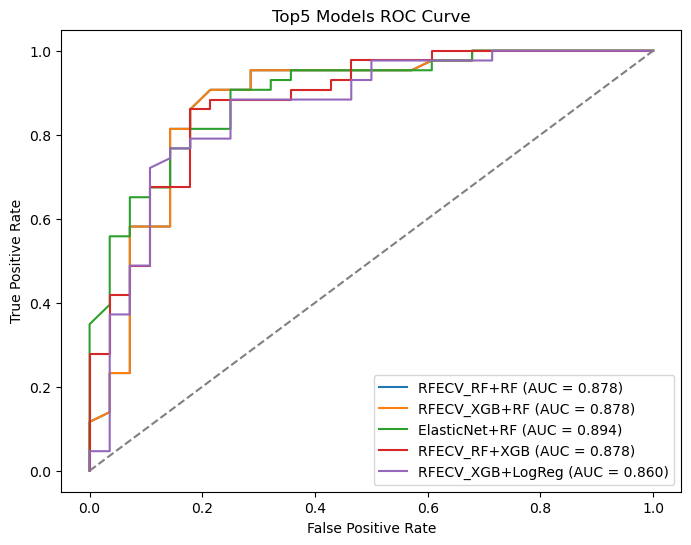

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, info in top_models.items():
    X_sel = X_test[info['vars']]
    model = info['model']

    # 학습 (전체 train)
    if isinstance(model, LogisticRegression):
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    else:
        pipe = Pipeline([('clf', model)])
    pipe.fit(X_train[info['vars']], y_train)

    # predict_proba
    try:
        y_score = pipe.predict_proba(X_sel)[:,1]
    except:
        y_score = pipe.decision_function(X_sel)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Top5 Models ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# 5 최적 모델 SHAP 변수 중요도 계산

In [115]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# ---------------------------------
# 1️⃣ 단일 훈련 기반 SHAP
# ---------------------------------
mask = fitted_pipe.named_steps['feature_selection'].support_
X_train_sel = X_train.loc[:, mask]
xgb_model = fitted_pipe.named_steps['clf']

explainer = shap.TreeExplainer(xgb_model)
X_shap = X_train_sel.sample(n=min(2000, len(X_train_sel)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_shap)

shap_df_train = pd.DataFrame({
    "feature": X_train_sel.columns,
    "shap_mean_abs": np.abs(shap_values).mean(axis=0),
    "shap_mean": shap_values.mean(axis=0)
}).sort_values(by="shap_mean_abs", ascending=False).reset_index(drop=True)

# 소수점 3자리 반올림
shap_df_train[["shap_mean_abs", "shap_mean"]] = shap_df_train[["shap_mean_abs", "shap_mean"]].round(3)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

display(shap_df_train)



,feature,shap_mean_abs,shap_mean
0,student_interact,0.925,0.052
1,theory_cls,0.691,0.081
2,prof_passion,0.673,0.010
3,work_fee,0.653,0.024
4,study_hard,0.507,0.074
5,course_variety,0.505,0.075
6,job_test,0.473,-0.006
7,students_diligent,0.451,0.060
8,exp_concours,0.451,0.035
9,peer_event,0.447,0.106


# 6 최적 모델 SHAP 및 ROC 시각화

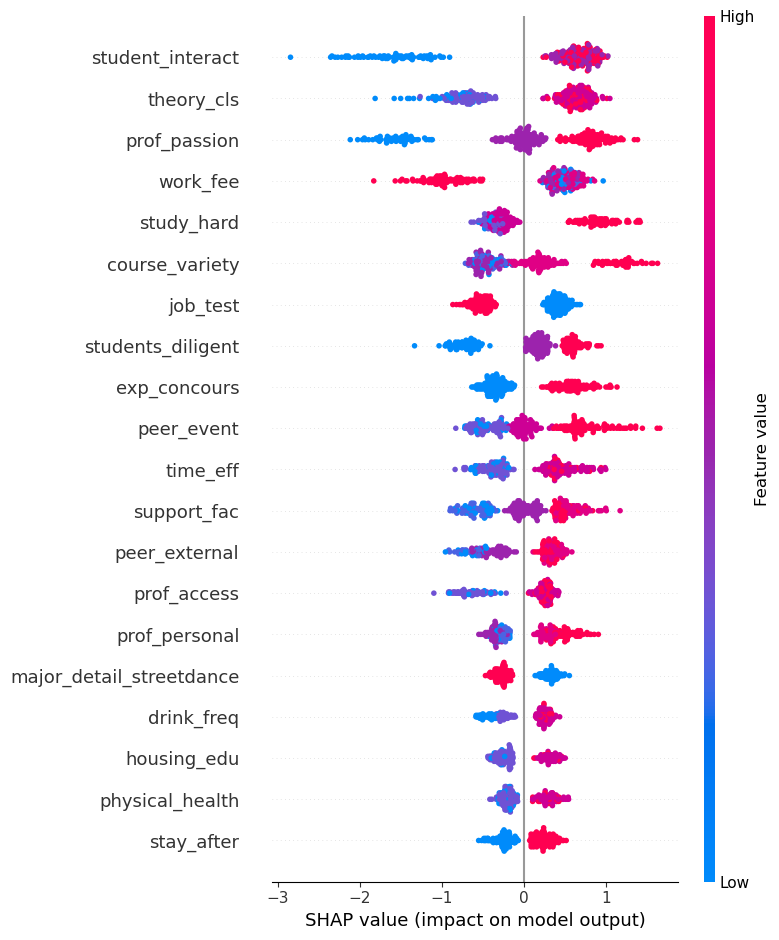

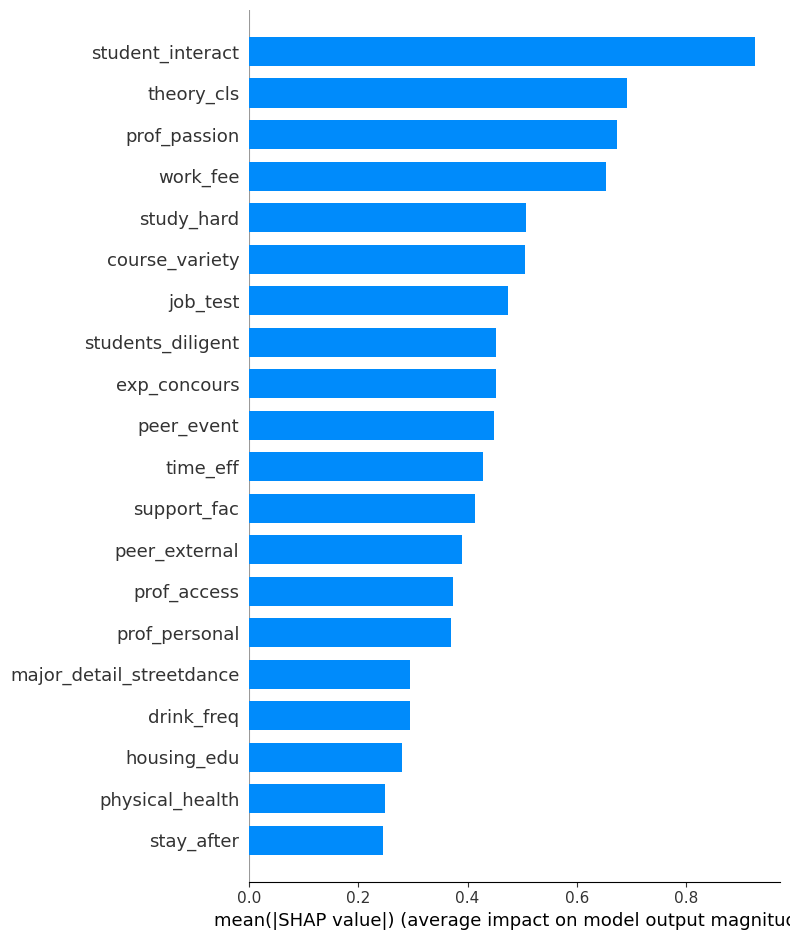

In [116]:
import shap
import matplotlib.pyplot as plt

# ---------------------------------
# 1️⃣ SHAP Summary Plot (Dot plot)
# ---------------------------------
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sel)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sel, plot_type="dot", show=True)

# ---------------------------------
# 2️⃣ SHAP Bar Plot (Feature importance based on mean(|SHAP|))
# ---------------------------------
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sel, plot_type="bar", show=True)


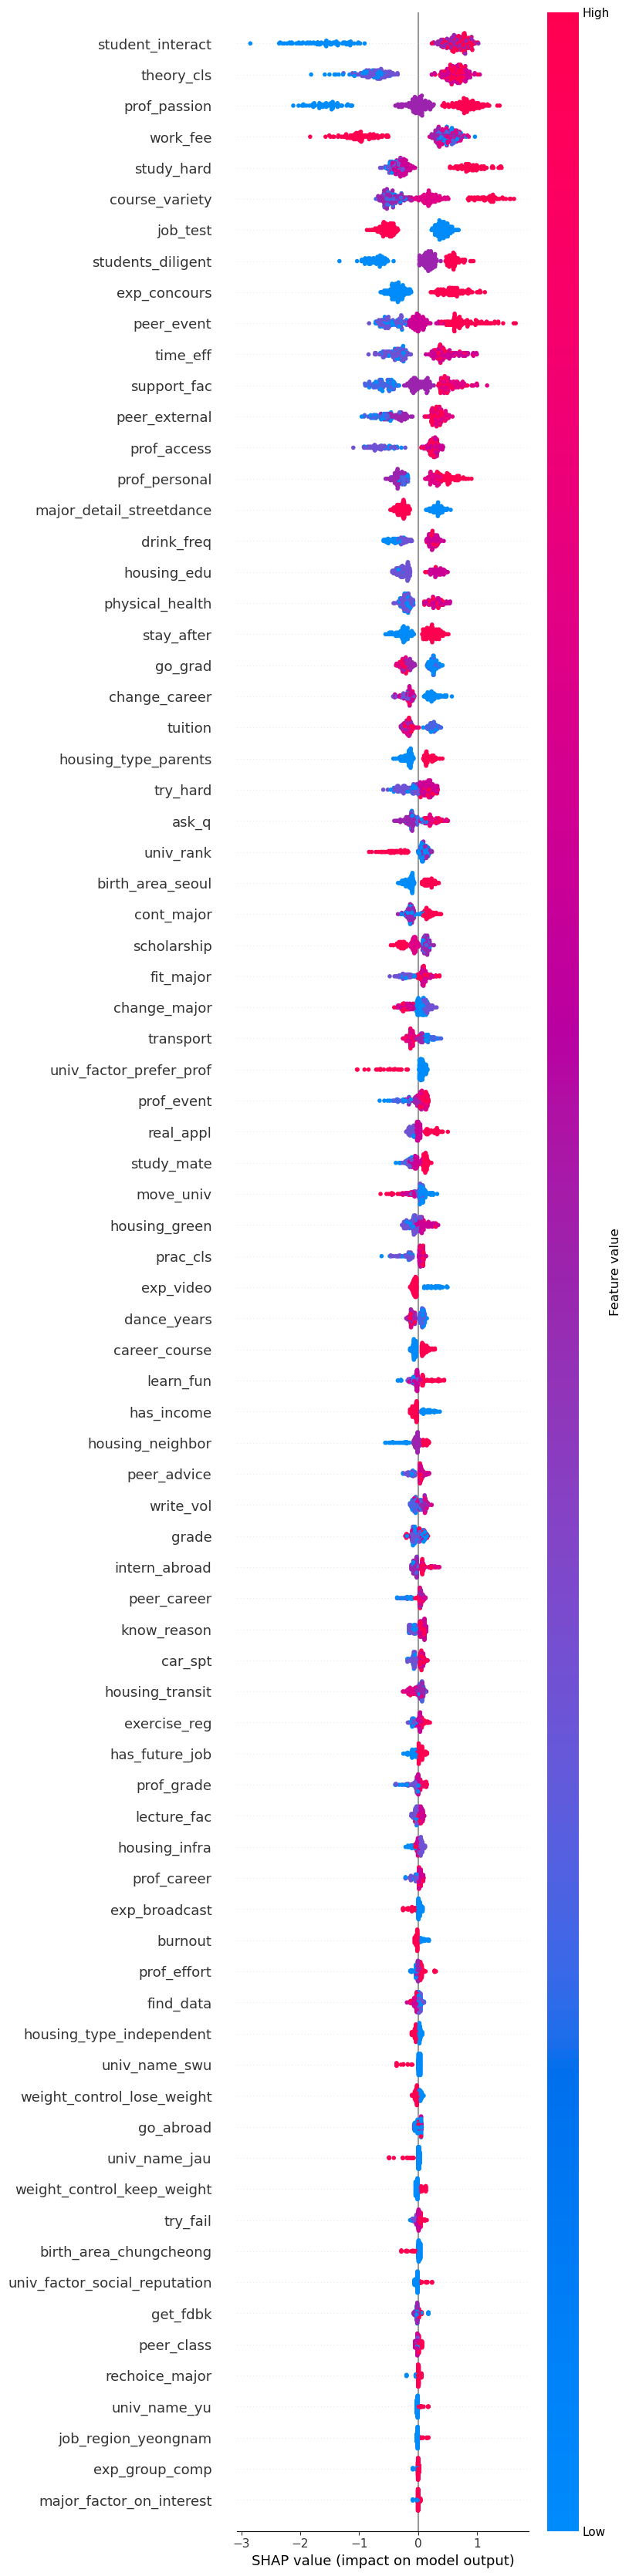

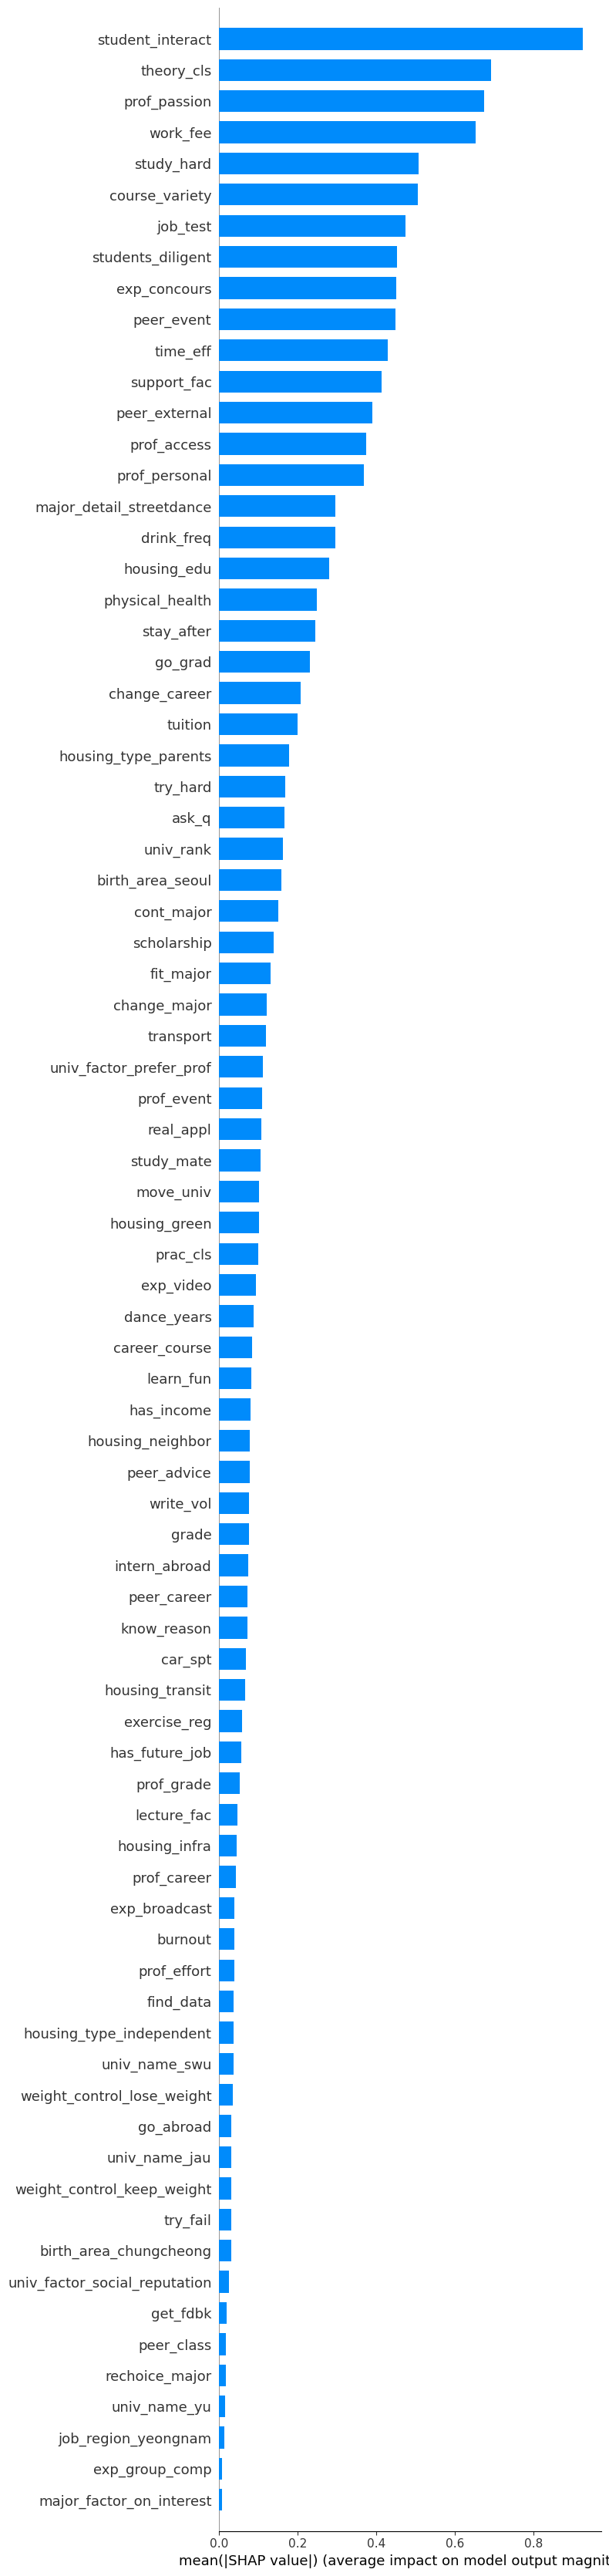

In [47]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sel)

# Dot plot: 전체 변수 표시
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sel, plot_type="dot", max_display=len(X_train_sel.columns), show=True)

# Bar plot: 전체 변수 표시
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sel, plot_type="bar", max_display=len(X_train_sel.columns), show=True)


# 기술통계 등 EDA 

In [48]:
import pandas as pd

# 1. 데이터 합치기
df_all = X.copy()
df_all['target'] = y

# 2. 1집단과 0집단 분리
group1 = df_all[df_all['target'] == 1]
group0 = df_all[df_all['target'] == 0]

# 3. 변수별 요약 통계 계산
summary_list = []
for col in X.columns:
    summary_list.append({
        'variable': col,
        'mean_all': df_all[col].mean(),
        'std_all': df_all[col].std(),
        'n_all': df_all[col].count(),
        'mean_1': group1[col].mean(),
        'std_1': group1[col].std(),
        'n_1': group1[col].count(),
        'mean_0': group0[col].mean(),
        'std_0': group0[col].std(),
        'n_0': group0[col].count()
    })

summary_df = pd.DataFrame(summary_list)

# 소숫점 둘째자리까지 반올림
summary_df = summary_df.round(2)

display(summary_df)


,variable,mean_all,std_all,n_all,mean_1,std_1,n_1,mean_0,std_0,n_0
0,univ_rank,1.65,0.79,355,1.52,0.73,215,1.84,0.83,140
1,major_rank,1.08,0.31,355,1.07,0.28,215,1.11,0.35,140
2,know_reason,3.74,0.97,355,4.06,0.84,215,3.26,0.96,140
3,prof_exp,3.94,0.86,355,4.17,0.76,215,3.59,0.90,140
4,study_hard,3.99,0.92,355,4.24,0.80,215,3.60,0.96,140
5,time_eff,3.49,0.96,355,3.75,0.88,215,3.09,0.93,140
6,edu_doubt,3.01,1.17,355,3.07,1.19,215,2.91,1.13,140
7,learn_fun,3.96,0.89,355,4.24,0.77,215,3.53,0.88,140
8,study_mate,4.24,0.94,355,4.46,0.80,215,3.90,1.04,140
9,try_hard,3.63,0.88,355,3.85,0.80,215,3.29,0.89,140


In [49]:
# 수치형 변수 t검정 
import pandas as pd
from scipy.stats import ttest_ind

# -------------------------
# target 포함 df_all
# -------------------------
df_all = df.copy()
df_all["target"] = df_all["sat_group"]

# -------------------------
# 원핫인코딩된 컬럼 패턴 (범주형)
# -------------------------
cat_prefixes = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]

# -------------------------
# 이진형 변수
# -------------------------
bin_vars = [
    'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'exp_perf', 'exp_video', 'exp_broadcast',
    'gender','career_course', 'career_mentoring', 'job_test', 'job_prep',
    'field_practice', 'abroad_practice', 'job_info', 'job_fair',
    'move_for_univ', 'stay_after', 'has_future_job', 'has_income',
    'has_major_income', 'rechoice_major' ,'burnout'
]

# -------------------------
# 수치형 변수 목록 (원핫, 이진 변수 제외)
# -------------------------
numeric_vars = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_vars = [col for col in numeric_vars if col not in ["sat", "sat_group"]]
numeric_vars = [
    col for col in numeric_vars
    if not any(col.startswith(prefix + "_") for prefix in cat_prefixes)
    and col not in bin_vars
]

# -------------------------
# t-test 수행 및 p-value 등급, 집단별 mean(std) 추가
# -------------------------
ttest_results = []

for col in numeric_vars:
    group0 = df_all[df_all["target"]==0][col]
    group1 = df_all[df_all["target"]==1][col]
    
    # 독립표본 t-test (등분산 가정=False)
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False, nan_policy='omit')
    
    # 유의 수준 확인
    if p_val < 0.001:
        p_level = "<0.001"
    elif p_val < 0.01:
        p_level = "<0.01"
    elif p_val < 0.05:
        p_level = "<0.05"
    else:
        continue  # p >= 0.05이면 결과에서 제외
    
    ttest_results.append({
        "variable": col,
        "t_stat": round(t_stat, 3),
        "p_value": round(p_val, 6),
        "p_level": p_level,
        "mean_group0": f"{group0.mean():.2f} ({group0.std():.2f})",
        "mean_group1": f"{group1.mean():.2f} ({group1.std():.2f})"
    })

# -------------------------
# 결과 DataFrame (p-value 기준 정렬)
# -------------------------
ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values("p_value").reset_index(drop=True)

print(ttest_df)


             variable  t_stat   p_value p_level  mean_group0  mean_group1
0         lecture_fac  -6.626  0.000000  <0.001  3.20 (0.95)  3.89 (0.98)
1            prac_cls  -8.832  0.000000  <0.001  3.33 (0.95)  4.19 (0.82)
2          theory_cls  -9.914  0.000000  <0.001  3.12 (0.94)  4.10 (0.86)
3         prof_effort  -8.981  0.000000  <0.001  3.58 (0.87)  4.39 (0.75)
4          admin_serv  -8.065  0.000000  <0.001  3.06 (0.91)  3.87 (0.92)
5             car_spt  -8.711  0.000000  <0.001  3.03 (1.01)  3.96 (0.95)
6       intern_abroad  -6.977  0.000000  <0.001  2.84 (1.04)  3.64 (1.11)
7     prof_class_talk  -6.709  0.000000  <0.001  3.96 (0.86)  4.54 (0.69)
8     prof_other_talk  -7.297  0.000000  <0.001  3.71 (0.99)  4.43 (0.78)
9         prof_career  -8.273  0.000000  <0.001  3.19 (1.05)  4.10 (0.96)
10      prof_personal  -8.600  0.000000  <0.001  2.86 (1.15)  3.95 (1.18)
11         prof_grade  -7.392  0.000000  <0.001  3.11 (1.11)  4.00 (1.10)
12        support_fac  -6.062  0.00000

In [50]:
print("수치형 변수 개수:", len(numeric_vars))
print("수치형 변수 목록:", numeric_vars)


수치형 변수 개수: 75
수치형 변수 목록: ['id', 'univ_rank', 'major_rank', 'know_reason', 'prof_exp', 'study_hard', 'time_eff', 'edu_doubt', 'learn_fun', 'study_mate', 'try_hard', 'write_vol', 'find_data', 'self_study', 'try_fail', 'get_fdbk', 'real_appl', 'ask_q', 'fit_major', 'cont_major', 'move_univ', 'change_major', 'change_career', 'take_leave', 'drop_out', 'go_abroad', 'go_grad', 'work_fee', 'smoke_exp', 'drink_freq', 'exercise_reg', 'mental_health', 'physical_health', 'housing_infra', 'housing_transit', 'housing_safety', 'housing_hygiene', 'housing_green', 'housing_culture', 'housing_edu', 'housing_neighbor', 'lecture_fac', 'support_fac', 'scholarship', 'tuition', 'transport', 'prac_cls', 'theory_cls', 'prof_effort', 'admin_serv', 'car_spt', 'intern_abroad', 'prof_class_talk', 'prof_other_talk', 'prof_career', 'prof_personal', 'prof_grade', 'prof_event', 'peer_class', 'peer_career', 'peer_advice', 'peer_event', 'peer_external', 'students_diligent', 'course_variety', 'student_interact', 'prof_pa

In [51]:
# 범주형 변수 카이검정 
import pandas as pd
from scipy.stats import chi2_contingency

df_all = df.copy()
df_all["target"] = df_all["sat_group"]

cat_prefixes = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]

bin_vars = [
    'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'gender',
    'career_course', 'career_mentoring', 'job_test', 'job_prep',
    'field_practice', 'abroad_practice', 'job_info', 'job_fair',
    'move_for_univ', 'stay_after', 'has_future_job', 'has_income',
    'has_major_income', 'rechoice_major','burnout','exp_perf', 'exp_video', 'exp_broadcast'
]

chi_results = []

# 함수: 교차표 + 행 기준 비율 + 전체 대비 비율 + chi2
def process_variable(var_name, df, target="target"):
    crosstab = pd.crosstab(df[var_name], df[target])
    row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    total_pct = crosstab.div(len(df)) * 100
    display_table = crosstab.astype(str) + " (" + row_pct.round(1).astype(str) + "% / " + total_pct.round(1).astype(str) + "%)"
    
    print(f"\n=== {var_name} vs 만족도 ===")
    print(display_table)
    
    if crosstab.shape[0] > 1:
        chi2, p, dof, expected = chi2_contingency(crosstab)
        print(f"\n>>> {var_name} 카이제곱 검정 결과: chi2={chi2:.3f}, df={dof}, p={p:.6f} ({'유의' if p < 0.05 else '비유의'})")
        chi_results.append({
            "variable": var_name,
            "chi2": round(chi2, 3),
            "dof": dof,
            "p_value": round(p, 6),
            "significant": "유의" if p < 0.05 else "비유의"
        })

# 범주형 변수 처리
for prefix in cat_prefixes:
    cols = [c for c in df_all.columns if c.startswith(prefix + "_")]
    if not cols:
        continue

    df_all[cols] = df_all[cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    df_all[f"{prefix}_raw"] = df_all[cols].idxmax(axis=1).str.replace(prefix + "_", "")
    process_variable(f"{prefix}_raw", df_all)

# 이진형 변수 처리
for col in bin_vars:
    if col not in df_all.columns:
        continue
    process_variable(col, df_all)

# 카이제곱 요약
chi_df = pd.DataFrame(chi_results).sort_values(by="p_value").reset_index(drop=True)
print("\n=== 카이제곱 결과 요약 (p-value 기준 정렬) ===")
print(chi_df)



=== univ_factor_raw vs 만족도 ===
target                             0                   1
univ_factor_raw                                         
commute_near       13 (46.4% / 3.7%)   15 (53.6% / 4.2%)
edu_duration        5 (71.4% / 1.4%)    2 (28.6% / 0.6%)
edu_structure       5 (17.9% / 1.4%)   23 (82.1% / 6.5%)
etc                 3 (75.0% / 0.8%)    1 (25.0% / 0.3%)
grade_fit          11 (44.0% / 3.1%)   14 (56.0% / 3.9%)
in_seoul           1 (100.0% / 0.3%)     0 (0.0% / 0.0%)
job_prospects       4 (30.8% / 1.1%)    9 (69.2% / 2.5%)
low_tuition         8 (61.5% / 2.3%)    5 (38.5% / 1.4%)
major_apportunity  28 (29.5% / 7.9%)  67 (70.5% / 18.9%)
official_univ      1 (100.0% / 0.3%)     0 (0.0% / 0.0%)
parent_teacher     19 (50.0% / 5.4%)   19 (50.0% / 5.4%)
peer_advice         6 (46.2% / 1.7%)    7 (53.8% / 2.0%)
prefer_prof        14 (50.0% / 3.9%)   14 (50.0% / 3.9%)
social_reputation  20 (33.9% / 5.6%)  39 (66.1% / 11.0%)
total              2 (100.0% / 0.6%)     0 (0.0% / 0.0%)

In [52]:
# cat_prefixes 원핫 → 단일값으로 복원
categorical_vars_raw = [f"{prefix}_raw" for prefix in cat_prefixes]

# bin_vars 그대로
categorical_vars_bin = [col for col in bin_vars if col in df_all.columns]

# 전체 범주형 변수 목록
categorical_vars_all = categorical_vars_raw + categorical_vars_bin

print("범주형 변수 개수:", len(categorical_vars_all))
print("범주형 변수 목록:", categorical_vars_all)


범주형 변수 개수: 32
범주형 변수 목록: ['univ_factor_raw', 'major_factor_raw', 'job_region_raw', 'weight_control_raw', 'birth_area_raw', 'housing_type_raw', 'enter_type_raw', 'major_detail_raw', 'univ_name_raw', 'univ_area_raw', 'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'gender', 'career_course', 'career_mentoring', 'job_test', 'job_prep', 'field_practice', 'abroad_practice', 'job_info', 'job_fair', 'move_for_univ', 'stay_after', 'has_future_job', 'has_income', 'has_major_income', 'rechoice_major', 'burnout', 'exp_perf', 'exp_video', 'exp_broadcast']


In [53]:
# 전처리 후 최종 변수 목록
final_vars = df.columns.tolist()
print("총 변수 수:", len(final_vars))
print("변수 목록:")
for var in final_vars:
    print(var)


총 변수 수: 178
변수 목록:
id
univ_rank
major_rank
know_reason
prof_exp
study_hard
time_eff
edu_doubt
learn_fun
study_mate
try_hard
write_vol
find_data
self_study
try_fail
get_fdbk
real_appl
ask_q
fit_major
cont_major
rechoice_major
move_univ
change_major
change_career
take_leave
drop_out
go_abroad
go_grad
work_fee
has_future_job
has_income
has_major_income
smoke_exp
drink_freq
exercise_reg
burnout
mental_health
physical_health
housing_infra
housing_transit
housing_safety
housing_hygiene
housing_green
housing_culture
housing_edu
housing_neighbor
move_for_univ
stay_after
lecture_fac
support_fac
scholarship
tuition
transport
prac_cls
theory_cls
prof_effort
admin_serv
car_spt
intern_abroad
career_course
career_mentoring
job_test
job_prep
field_practice
abroad_practice
job_info
job_fair
prof_class_talk
prof_other_talk
prof_career
prof_personal
prof_grade
prof_event
peer_class
peer_career
peer_advice
peer_event
peer_external
students_diligent
course_variety
student_interact
prof_passion
prof_access